[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/use-cases/bare-soil-detector/bare-soil-detector.ipynb)

# Detecting Bare Soil

In today’s world of precision agriculture and environmental monitoring, the ability to detect and track bare soil periods is becoming increasingly important. This script leverages satellite data to illustrate the process of identifying these periods in agricultural fields, showcasing the capabilities of our platform. Please note that while this notebook uses a straightforward approach to demonstrate key concepts, our [Area Monitoring](https://area-monitoring.sinergise.com/) system employs more sophisticated models designed for robust, large-scale analysis. This notebook serves as an introductory example to help users understand the basic methodology and potential of our platform.

## Why Detecting Bare Soil Matters

Identifying periods of bare soil is crucial for several reasons:

1. Soil Health: Bare soil is more susceptible to erosion, nutrient loss, and degradation. By knowing when soil is exposed, farmers can take protective measures.

2. Water Management: Bare soil affects water retention and runoff patterns. Understanding these periods helps in planning irrigation and managing water resources more effectively.

3. Carbon Sequestration: Soil exposed to the atmosphere releases carbon. Minimizing bare soil periods can help in carbon sequestration efforts, contributing to climate change mitigation.

4. Crop Rotation Planning: Knowledge of bare soil periods aids in planning optimal crop rotations and cover crop strategies, enhancing overall soil fertility and crop yields.

5. Compliance and Sustainability: Many agricultural policies and sustainability certifications require minimizing bare soil exposure. This tool helps in monitoring and compliance.

6. Biodiversity: Bare soil periods can impact local ecosystems. Understanding these periods helps in managing biodiversity in agricultural landscapes.

## From Data to Action

By visualizing bare soil probabilities over time and clearly identifying bare soil periods, farmers and land managers can:

1. Plan timely interventions to protect exposed soil

2. Optimize planting and harvesting schedules

3. Implement targeted conservation practices

4. Make data-driven decisions about land use and crop management

## Overview
In this notebook, we combine several powerful tools to analyze agricultural fields over time:

1. Data Retrieval: We use the Sentinel Hub API to fetch satellite imagery data for a specific field over a given time range.

2. Index Calculation: The script calculates various spectral indices, including MSAVI (Modified Soil Adjusted Vegetation Index), BSI (Bare Soil Index), NDTI (Normalized Difference Tillage Index), TI (Tillage Index), and NDBI (Normalized Difference Built-up Index).

3. Bare Soil Probability: Using a combination of these indices, we estimate the probability of bare soil for each data point.

4. Time Series Analysis: The script processes this data into a time series, allowing us to track changes over time.

5. Bare Soil Period Identification: We identify continuous periods where the bare soil probability exceeds a certain threshold.

6. Visualization: The results are visualized in two graphs: one showing all indices over time, and another focusing specifically on bare soil probability.

In [ ]:
import getpass
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from sentinelhub import (
    Geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    MimeType
)

## Credentials

The Sentinel Hub Python SDK requires a `client_id` and a `client_secret`. To obtain your `client_id` & `client_secret`, you need to navigate to your [account manager](insights.planet.com/account/), and in the **User Settings**, create a new OAuth client. More detailed instructions can be found in our [authentication documentation](https://docs.planet.com/develop/authentication/).

Once you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [in the documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite the default profile every time you run a new Jupyter Notebook.

The following cell checks for an existing default configuration. If none is found, you will be prompted for your credentials, which you can then optionally save.

In [ ]:
from sentinelhub import SHConfig

# Authenticate with the Sentinel Hub Python SDK; See docs: https://sentinelhub-py.readthedocs.io/en/latest/configure.html and https://docs.planet.com/develop/authentication
# If no default configuration detected, enter a client ID and secret to authenticate. These can be obtained by creating an OAuth client here: https://insights.planet.com/account
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    from getpass import getpass
    print('No credentials found, please provide the OAuth client ID and secret.')
    config.sh_client_id = getpass('Client ID: ')
    config.sh_client_secret = getpass('Client Secret: ')
    ## Uncomment the following lines to save your credentials to a configuration
    # config.save() 
    # print(f'Credentials saved to {SHConfig.get_config_location()}')
else:
    print(f'Using credentials stored here: {SHConfig.get_config_location()}')

In [55]:
# Load GeoJSON into a shapely polygon
foi_json = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"coordinates":[[[-0.558261016622879,45.967967918251816],[-0.5583688254861556,45.967580759585644],[-0.5585485069244385,45.967143641710436],[-0.5588180290806406,45.9666940311547],[-0.5594648822587658,45.96663158495545],[-0.5596984681280901,45.96297211475388],[-0.5581352396168313,45.96289717427143],[-0.5570212147001143,45.96289717427143],[-0.5561048393657586,45.96293464452532],[-0.5548650374429371,45.96330934566902],[-0.5540924072599864,45.96403376069415],[-0.5539666302526598,45.964770655914435],[-0.5549189418751723,45.965407625240545],[-0.5565720111055725,45.96645673522326],[-0.5569313739809445,45.96685639094292],[-0.558261016622879,45.967967918251816]]],"type":"Polygon"}}]}
foi_polygon = Polygon(foi_json["features"][0]["geometry"]["coordinates"][0])

# Convert shapely polygon to a Geometry object
foi = Geometry(foi_polygon, crs=CRS(4326))

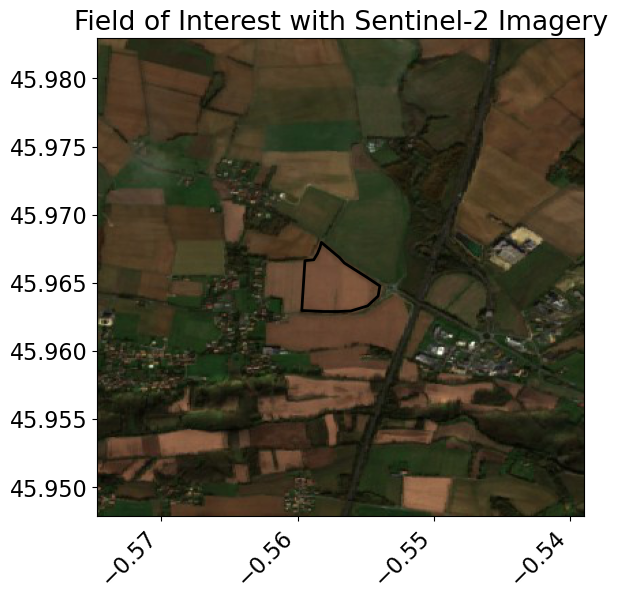

In [56]:
# Buffer the bounding box
buffer = 0.015
minx, miny, maxx, maxy = foi_polygon.bounds
bbox_buffered = Polygon([
    (minx - buffer, miny - buffer),
    (maxx + buffer, miny - buffer),
    (maxx + buffer, maxy + buffer),
    (minx - buffer, maxy + buffer)
])
foi_buffered = Geometry(bbox_buffered, crs=CRS(4326))


evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2024-11-01', '2024-11-30')
        )
    ],
    responses=[SentinelHubRequest.output_response('default', MimeType.JPG)],
    geometry=foi_buffered,  
    resolution=(.0001,.0001),
    config=config
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, extent=(minx - buffer, maxx + buffer, miny - buffer, maxy + buffer), origin='upper')

# Plot the polygon outline
gpd.GeoSeries([foi_polygon]).plot(
    ax=ax,
    color='none',
    edgecolor='black',
    linewidth=2
)

ax.set_aspect('equal')
ax.ticklabel_format(useOffset=False, style='plain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
ax.set_title("Field of Interest with Sentinel-2 Imagery")

plt.show()

### Prepare the evalscscript for Bare Soil Calculation

The script calculates various spectral indices:
- NDVI (Normalized Difference Vegetation Index) [reference](https://www.sciencedirect.com/science/article/abs/pii/S0034425797001041)
- BSI (Bare Soil Index) [reference](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/)
- NDBI (Normalized Difference Built-up Index) [reference](https://www.tandfonline.com/doi/pdf/10.1080/01431160304987)
- TI (Tillage Index) [reference](https://www.asprs.org/wp-content/uploads/pers/1997journal/jan/1997_jan_87-93.pdf)
- NDTI (Normalized Difference Tillage Index) [reference](https://www.asprs.org/wp-content/uploads/pers/1997journal/jan/1997_jan_87-93.pdf)


In [57]:
evalscript = """//VERSION=3

function setup() {
  return {
        input: [{
            bands: ["B03", "B04", "B08", "B11", "B12", "SCL", "dataMask"],
        }],
    output: [
      { id: "msavi", bands: 1, sampleType: "FLOAT32" },
      { id: "bsi", bands: 1, sampleType: "FLOAT32" },
      { id: "ndti", bands: 1, sampleType: "FLOAT32" },
      { id: "ti", bands: 1, sampleType: "FLOAT32"},
      { id: "ndbi", bands: 1, sampleType: "FLOAT32"},
      { id: "bareSoil_Prob", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function isCloud(scl) {
  // Compute clouds based on SCL layer
  const cloudValues = [1, 3, 8, 9, 10];
  return cloudValues.includes(scl);
}
function evaluatePixel(sample) {
  // Modified Soil Adjusted Vegetation Index  (abbrv. MSAVI)
  // https://doi.org/10.1016/0034-4257(94)90134-1 and https://www.indexdatabase.de/db/i-single.php?id=44
  let msavi = (2.0 * sample.B08 + 1.0 - Math.sqrt(Math.pow((2.0 * sample.B08 + 1.0), 2.0) - 8.0 * (sample.B08 - sample.B04))) / 2.0;

  // Bare Soil Index (BSI)
  let bsi = ((sample.B11 + sample.B04) - (sample.B08 + sample.B04)) / ((sample.B11 + sample.B04) + (sample.B08 + sample.B04));

  // Normalized Difference Built-up Index (NDBI)
  let ndbi = index(sample.B11, sample.B08);
  
  // Tillage Index (TI)
  // https://www.asprs.org/wp-content/uploads/pers/1997journal/jan/1997_jan_87-93.pdf
  let ti = sample.B11 / sample.B12;

  // Normalized Difference Tillage Index (NDTI)
  // https://www.asprs.org/wp-content/uploads/pers/1997journal/jan/1997_jan_87-93.pdf
  let ndti = (sample.B11 - sample.B12)/(sample.B11 + sample.B12)

  // Simple bare soil probability (example threshold-based approach)
  let bareSoil_Prob = (msavi < 0.2 && bsi > 0 && ndbi > 0) ? 1.0 : 0.0;
  
  let is_cloud = isCloud(sample.SCL);
  let is_water = (sample.SCL == 6);
  let mask = sample.dataMask && !is_cloud ? 1 : 0 && !is_water ? 1 : 0;

  return {
    msavi: [msavi],
    bsi: [bsi],
    ndti: [ndti],
    ti: [ti],
    ndbi: [ndbi],
    bareSoil_Prob: [bareSoil_Prob],
    dataMask: [mask],
  };
}
"""

### Statistical API
We will generate the time series for the average of the these indices using the Statistical API with the following parameters:

- Sentinel 2 Level 2A data
- Evalscript defined above
- Time of interest from January 1st, 2019 to November 1st, 2024
- At the native resolution (`0.0001` degree -> ±10m)
- Calculated for each day `(P1D)`
- Over the geometry our field of interest `(foi)`

<div class="alert alert-block alert-info">
<b>Processing Units:</b> The following code block will consume processing units.
</div>

In [58]:
time_of_interest = "2019-01-01", "2024-11-01"
input_data = SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L2A)

# Set up request
request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(evalscript=evalscript, 
                                                    time_interval=time_of_interest, 
                                                    aggregation_interval="P1D", 
                                                    resolution=(0.0001, 0.0001)), 
                                                    input_data=[input_data],
                                                    geometry=foi,
                                                    config=config,
                                                    )

# Make request and download response
download_requests = [request.download_list[0]]
client = SentinelHubDownloadClient(config=config)
response = client.download(download_requests)

### Outputs retrieval

In [59]:
# JSON data to DataFrame
series = pd.json_normalize(response[0]["data"])

# Convert 'interval.from' to datetime and set it as the index
series['date'] = pd.to_datetime(series['interval.from'])
series['date'] = series['date'].dt.date
series.set_index('date', inplace=True)

# Drop unnecessary columns
series.drop(columns=['interval.from', 'interval.to'], inplace=True)

# Convert all columns to numeric, coercing errors to NaN
series = series.apply(pd.to_numeric, errors='coerce')

### Calculate the coverage 
Cloud cover in satellite images can obscure ground features, reducing the reliability of spectral indices (e.g., NDVI, NDBI) and the accuracy outputs. By calculating the coverage, we can identify and filter out cloudy date to ensures that analysis focuses on clear, unobstructed information.

In [60]:
# Calculate the percentage coverage
variable = "msavi"
min_coverage = 0.8 # 80% coverage

# Retrieve the noDataCount
no_data_count = series[f"outputs.{variable}.bands.B0.stats.noDataCount"]

# Retrieve the total number of pixels
total_pixels = series[f"outputs.{variable}.bands.B0.stats.sampleCount"].unique()[0] - no_data_count.min()

series["coverage"]=percentage_coverage = (1 - (no_data_count - no_data_count.min()) / total_pixels)
series = series[series["coverage"]>=min_coverage]

### Time series of indices requested

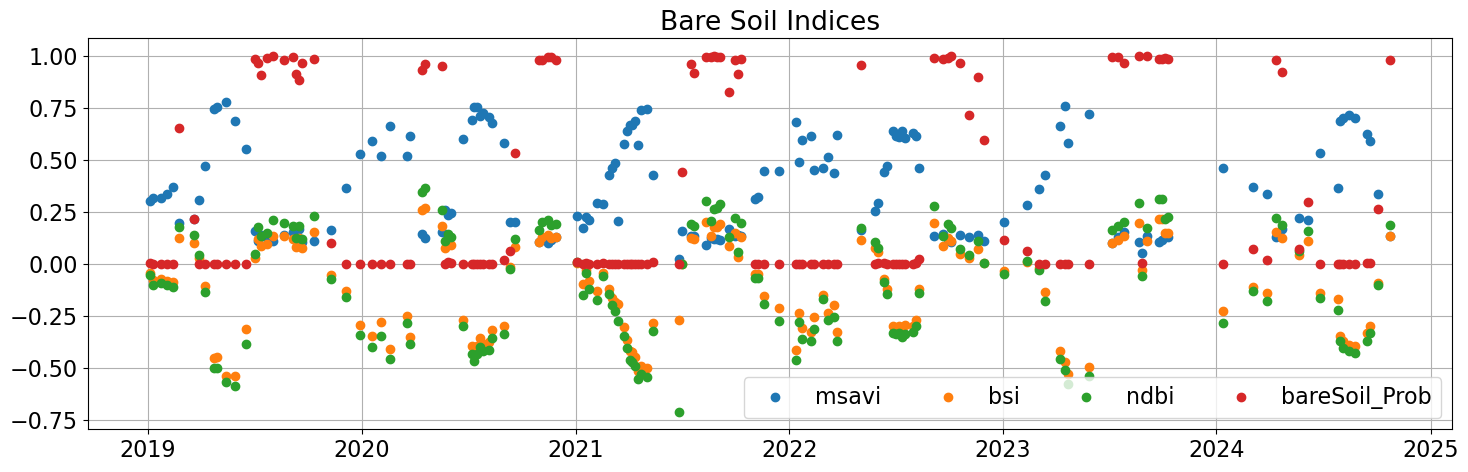

In [61]:
plt.rcParams.update({'font.size': 16})
indices = ["msavi", "bsi", "ndbi", "bareSoil_Prob"]
fig, ax = plt.subplots(figsize=(15, 5))
for index in indices:
    series[f"outputs.{index}.bands.B0.stats.mean"].plot(ax=ax, style="o", label=index)
plt.grid()
plt.legend(ncols=len(indices))
plt.title("Bare Soil Indices")
plt.legend(ncols=len(indices))
plt.xlabel("")
plt.tight_layout()

### Converting Bare Soil Probability to periods of Bare Soil

Because the data is not continous, the bare soil probability index is backward filled. 

- **Backward Fill (bfill):**
The bfill method is used to fill missing values in the DataFrame by propagating the next valid observation backward.
For example, if you have a sequence [0.1, None, None, 0.4], after applying bfill, it becomes [0.1, 0.4, 0.4, 0.4].

- **Storing Periods with Bare Soil:**
We initialize an empty dictionary bare_soil_periods.
We iterate over each row in the DataFrame using iterrows().
If the bare_soil_prob value is greater than 0.2, we store the date and the probability in the bare_soil_periods dictionary.

In [62]:
full_date_range = pd.date_range(start=series.index.min(), end=series.index.max(), freq='D')
bareSoil_Prob = series["outputs.bareSoil_Prob.bands.B0.stats.mean"].reindex(full_date_range)
bareSoil_Prob = bareSoil_Prob.bfill() >= 0.1

# Initialize variables
periods = []
start_date = None

# Iterate through the series to identify True periods
for date, value in bareSoil_Prob.items():
    if value and start_date is None:
        start_date = date
    elif not value and start_date is not None:
        periods.append({"start_date": start_date, "end_date": date - pd.Timedelta(days=1)})
        start_date = None

# Handle the case where the series ends with a True period
if start_date is not None:
    periods.append({"start_date": start_date, "end_date": bareSoil_Prob.index[-1]})

### Results in Numbers

In [63]:
# Calculate the number of periods
num_periods = len(periods)

# Calculate the number of days of bare soil and days with vegetation
days_bare_soil = sum((period["end_date"] - period["start_date"]).days + 1 for period in periods)
total_days = len(bareSoil_Prob)
days_with_vegetation = total_days - days_bare_soil

# Calculate the percentages
percentage_bare_soil = (days_bare_soil / total_days) * 100
percentage_with_vegetation = (days_with_vegetation / total_days) * 100

# Print the results
print(f"For the period {full_date_range[0].date()} to {full_date_range[-1].date()}:")
print(f"--------------------------------------------")
print(f"Number of bare soil periods: {num_periods}")
print(f"Number of days with bare soil: {days_bare_soil} ({percentage_bare_soil:.2f}%)")
print(f"Number of days with vegetation: {days_with_vegetation} ({percentage_with_vegetation:.2f}%)")


For the period 2019-01-04 to 2024-10-24:
--------------------------------------------
Number of bare soil periods: 12
Number of days with bare soil: 810 (38.19%)
Number of days with vegetation: 1311 (61.81%)


### Bonus Tillage events
https://www.mdpi.com/2072-4292/12/16/2665

In [64]:
# Set thresholds for detecting bare soil and tillage events
tillage_spike_threshold = 0.1   # Adjust based on expected spike size for tillage

# Define a tillage event as a significant increase in both TI and NDTI during bare soil
series['tillage_event'] = (
    (series["outputs.bareSoil_Prob.bands.B0.stats.mean"] >= 0.1) & 
    (series["outputs.ti.bands.B0.stats.mean"].diff() > tillage_spike_threshold) & 
    (series["outputs.ndti.bands.B0.stats.mean"].diff() > tillage_spike_threshold)
)
# Extract dates and values where tillage events occur
tillage_events = list(series[series['tillage_event']].index)

### Visual representation

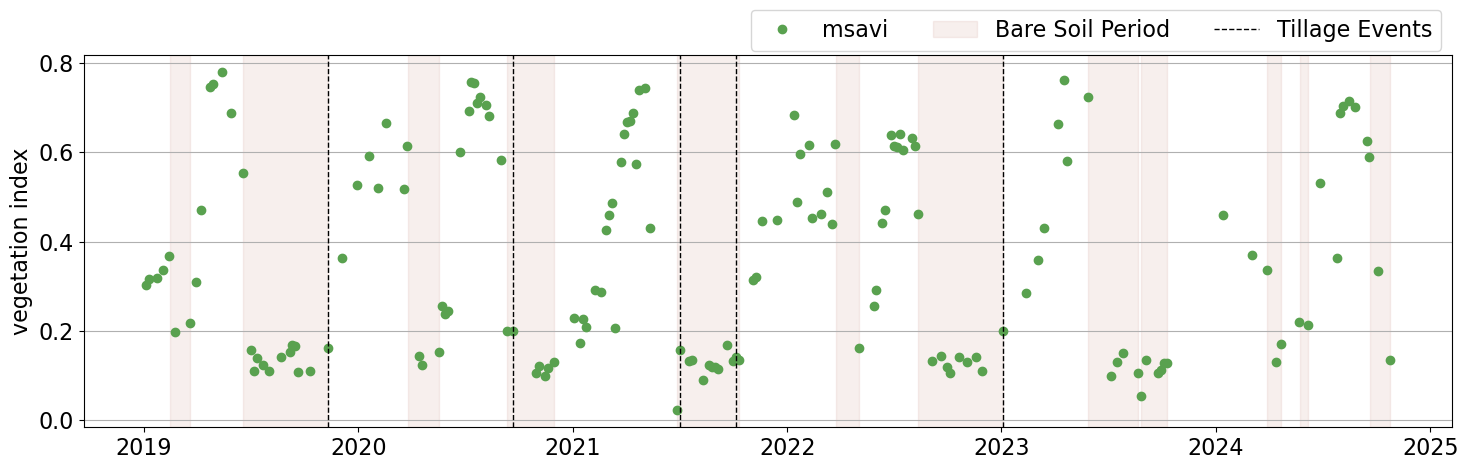

In [65]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(15, 5))
series[f"outputs.msavi.bands.B0.stats.mean"].plot(ax=ax, style="o", color="#59A14F", label="msavi")
handled_labels = set()
for period in periods:
    # Convert start and end of season to datetime
    start_of_season = pd.to_datetime(period['start_date'])
    end_of_season = pd.to_datetime(period['end_date'])

    label = 'Bare Soil Period'
    if label not in handled_labels:
        ax.axvspan(start_of_season, end_of_season, color='#B66353', alpha=0.1, label=label)
        handled_labels.add(label)
    else:
        ax.axvspan(start_of_season, end_of_season, color='#B66353', alpha=0.1)

# Plot vertical lines for tillage events detected
for date in tillage_events:
    label = 'Tillage Events'
    if label not in handled_labels:
        ax.axvline(pd.to_datetime(date), color='k', linestyle='--', linewidth=1, label=label)
        handled_labels.add(label)
    else:
        ax.axvline(pd.to_datetime(date), color='k', linestyle='--', linewidth=1)

plt.legend(ncols=3, bbox_to_anchor=(1, 1.15))
plt.ylabel("vegetation index")
plt.xlabel("")
plt.grid(axis="y")
plt.tight_layout()